In [222]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
import matplotlib.colors as colors

from nanonets.utils import fft, harmonic_strength, total_harmonic_distortion, sinusoidal_voltages
from scipy import signal

plt.style.use(["science","bright","grid"])
# PATH = "/home/jonasmensing/bagheera/data/2_funding_period/dynamic/AC/amp_freq/"
PATH = "/home/j/j_mens07/bagheera/data/2_funding_period/dynamic/AC/freq_manipulation/"

In [203]:
N_NP            = 9
STAT_SIZE_BASE  = 10
N_PERIODS       = 100
N_SAMPLES       = 1280
SAMPLE_P_PERIOD = 40
F0              = 28.0
AMPLITUDE       = 0.02
U_BOUNDS        = 0.05
N_EQ_PERIODS    = 20

f0_hz       = F0 * 1e6
dt          = 1 / (SAMPLE_P_PERIOD * f0_hz)
T_sim       = N_PERIODS / f0_hz
N_steps     = int(np.ceil(T_sim / dt))
stat_size   = max(STAT_SIZE_BASE, int(np.round(300*F0/5.0)))

topo    = {"Nx": N_NP,"Ny": N_NP,
           "e_pos": [[(N_NP-1)//2, 0],[0, 0],[N_NP-1, 0],[0, (N_NP-1)//2],[N_NP-1, (N_NP-1)//2],[0, N_NP-1],[N_NP-1, N_NP-1],[(N_NP-1)//2, N_NP-1]],
           "electrode_type": ['constant']*8}

time_steps, base_volt = sinusoidal_voltages(N_steps, topo,amplitudes=[AMPLITUDE,0.,0.,0.,0.,0.,0.,0.],frequencies=[f0_hz,0.,0.,0.,0.,0.,0.,0.],time_step=dt)
t       = time_steps[:-N_EQ_PERIODS*SAMPLE_P_PERIOD-1]*1e9
x       = base_volt[N_EQ_PERIODS*SAMPLE_P_PERIOD:-1,:][:,0]*1000
y       = pd.read_csv(f"{PATH}/../amp_freq/Nx=9_Ny=9_Ne=8_28.000_0.020_constant.csv")['Observable'].values[N_EQ_PERIODS*SAMPLE_P_PERIOD:]*1e-6
xf, yf  = fft(y, dt)
xf      = xf * 1e-6
y_thd   = total_harmonic_distortion(y, f0_hz, dt, 18)
y_thd

np.float64(67.46375264619209)

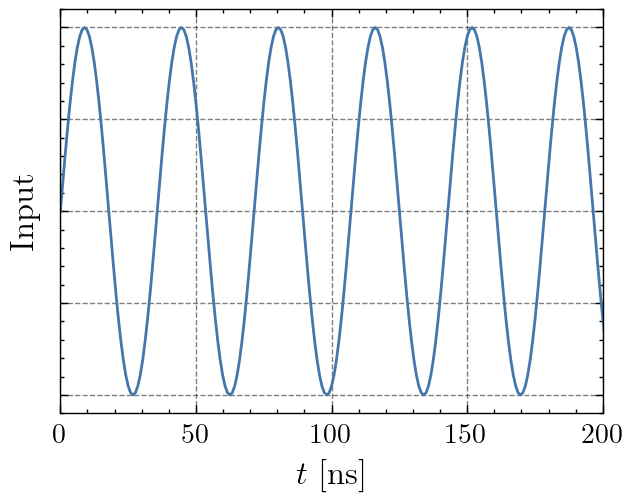

In [259]:
fig, ax = plt.subplots(dpi=200)
ax.plot(t, x)
ax.set_ylabel("Input", fontsize='large')
ax.set_xlabel("$t$ [ns]", fontsize='large')
ax.set_xlim(0,200)
_ = ax.set_yticklabels("")
fig.savefig("plots/freq_manipulation/input_signal.svg", transparent=True)

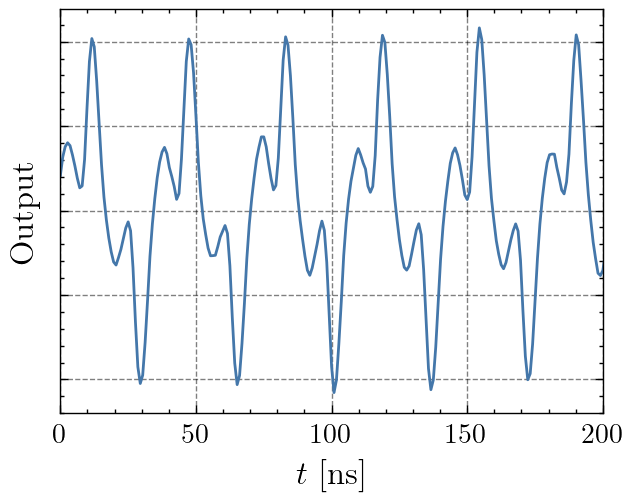

In [260]:
fig, ax = plt.subplots(dpi=200)
ax.plot(t, y)
ax.set_ylabel("Output", fontsize='large')
ax.set_xlabel("$t$ [ns]", fontsize='large')
ax.set_xlim(0,200)
_ = ax.set_yticklabels("")
fig.savefig("plots/freq_manipulation/output_signal_wo_controls.svg", transparent=True)

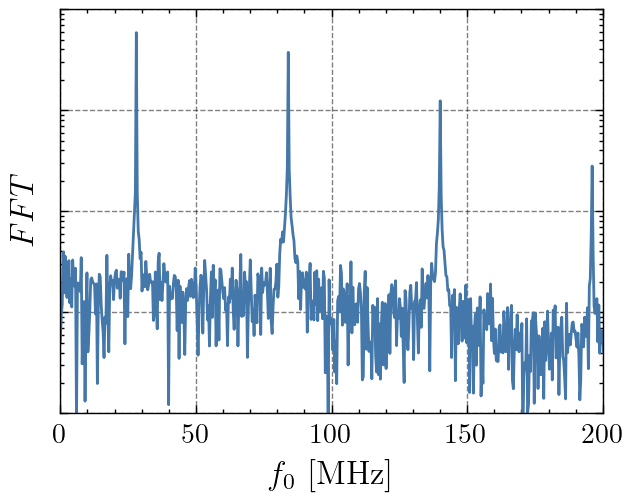

In [266]:
fig, ax = plt.subplots(dpi=200)
ax.plot(xf, yf)
ax.set_ylabel("$FFT$", fontsize='large')
ax.set_xlabel("$f_0$ [MHz]", fontsize='large')
ax.set_xlim(0,200)
ax.set_ylim(1e-3,10)
ax.set_yscale('log')
_ = ax.set_yticklabels("")
fig.savefig("plots/freq_manipulation/output_fft_wo_controls.svg", transparent=True)

In [ ]:
data = {i : pd.read_csv(f"{PATH}Nx=9_Ny=9_Ne=8_{i}.csv") for i in range(N_SAMPLES)}
data_new = [data[i].iloc[N_EQ_PERIODS*SAMPLE_P_PERIOD:].reset_index(drop=True)['Observable'].values*1e-9 for i in range(N_SAMPLES)]
thd_vals = [total_harmonic_distortion(data_new[i], f0_hz, dt, 4) for i in range(N_SAMPLES)]

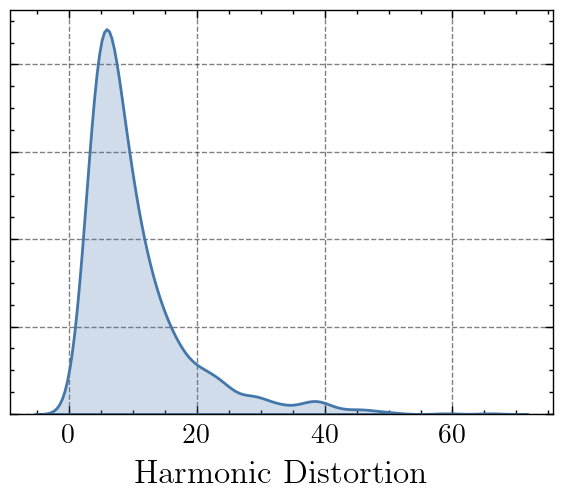

In [306]:
fig, ax = plt.subplots(dpi=200)
ax      = sns.kdeplot(thd_vals, fill=True)
ax.set_xlabel("Harmonic Distortion", fontsize='large')
ax.set_ylabel("")
_ = ax.set_yticklabels("")

fig.savefig("plots/freq_manipulation/harmonic_distortion.svg", transparent=True)

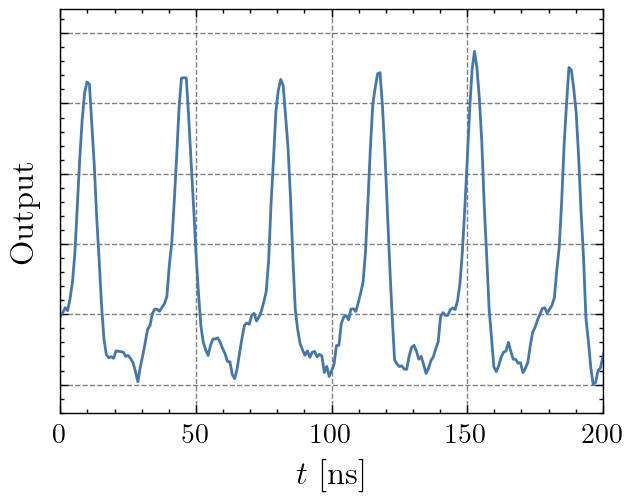

In [303]:
fig, ax = plt.subplots(dpi=200)
ax.plot(t, data_new[np.argmax(thd_vals)])
ax.set_ylabel("Output", fontsize='large')
ax.set_xlabel("$t$ [ns]", fontsize='large')
_ = ax.set_yticklabels("")
ax.set_xlim(0,200)
fig.savefig("plots/freq_manipulation/output_signal_max_thd.svg", transparent=True)

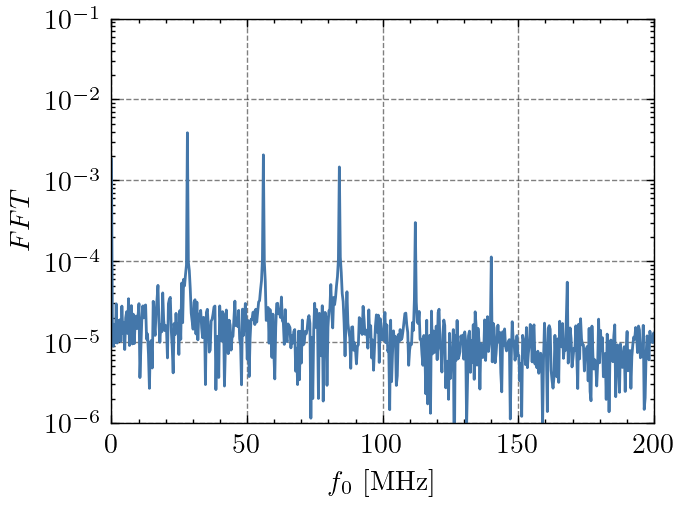

In [295]:
xf2, yf2 = fft(data_new[np.argmax(thd_vals)], dt)
xf2      = xf2 * 1e-6

fig, ax = plt.subplots(dpi=200)
ax.plot(xf2, yf2)
ax.set_ylabel("$FFT$")
ax.set_xlabel("$f_0$ [MHz]")
ax.set_xlim(0,200)
ax.set_ylim(1e-6,1e-1)
ax.set_yscale('log')

(0.0, 200.0)

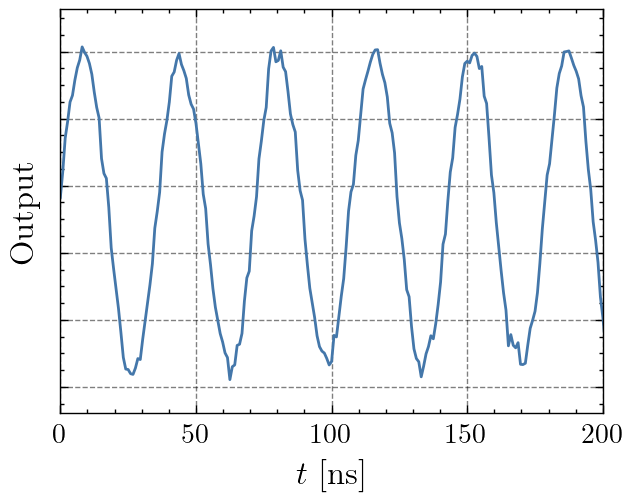

In [ ]:
fig, ax = plt.subplots(dpi=200)
ax.plot(t, data_new[np.argmin(thd_vals)])
ax.set_ylabel("Output", fontsize='large')
ax.set_xlabel("$t$ [ns]", fontsize='large')
_ = ax.set_yticklabels("")
ax.set_xlim(0,200)

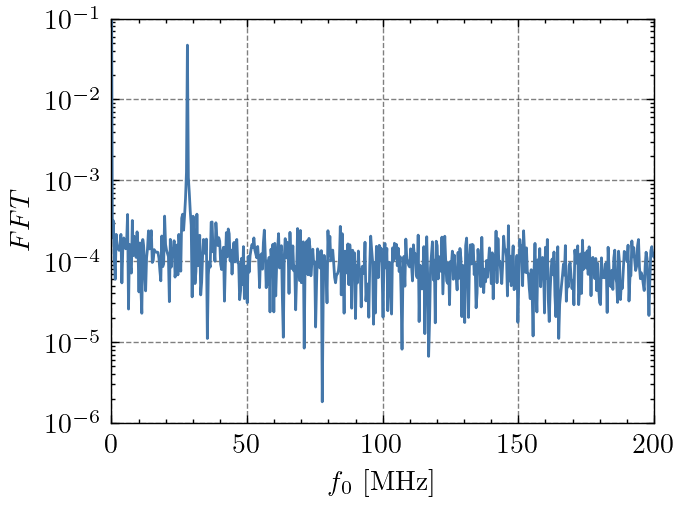

In [296]:
xf2, yf2 = fft(data_new[np.argmin(thd_vals)], dt)
xf2      = xf2 * 1e-6

fig, ax = plt.subplots(dpi=200)
ax.plot(xf2, yf2)
ax.set_ylabel("$FFT$")
ax.set_xlabel("$f_0$ [MHz]")
ax.set_xlim(0,200)
ax.set_ylim(1e-6,1e-1)
ax.set_yscale('log')

(0.0, 120.0)

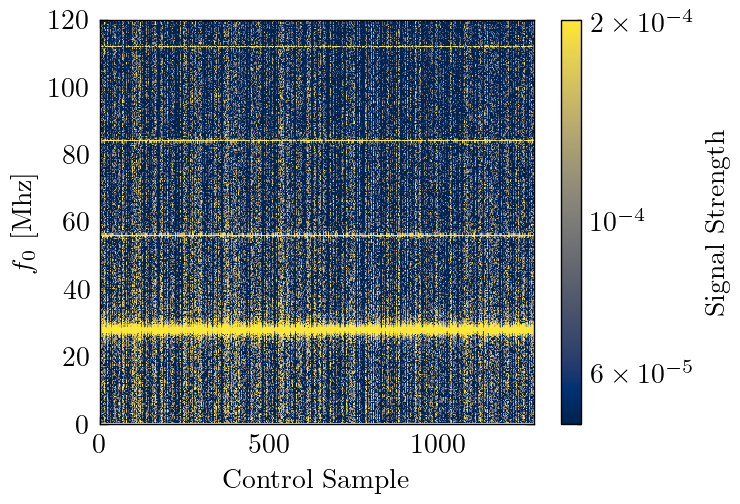

In [ ]:
fft_data = [fft(data_new[i], dt) for i in range(N_SAMPLES)]
xf_wf    = fft_data[0][0] * 1e-6
z_data   = np.array([yf for xf, yf in fft_data])

fig, ax = plt.subplots(dpi=200)
im = ax.pcolormesh(
    range(len(fft_data)),
    xf_wf,
    z_data.T,
    norm=colors.LogNorm(vmin=1e-5, vmax=1e-2),
    cmap='cividis'
)

# Add a color bar to show the mapping of colors to signal strength
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Signal Strength')

# Set the labels and title for clarity
ax.set_xlabel('Control Sample')
ax.set_ylabel('$f_0$ [Mhz]')

# Optional: Set the y-axis limit to focus on a specific frequency range
ax.set_ylim(0, 120)
fig.savefig("plots/freq_manipulation/waterfall_plot.svg", transparent=True)

In [298]:
def normalize_signal(s):
    """Removes DC offset and scales to [-1, 1]."""
    s_no_dc = s - np.mean(s)
    max_val = np.max(np.abs(s_no_dc))
    if max_val == 0:
        return s_no_dc
    return s_no_dc / max_val

def align_and_compare(s, ref):
    """Aligns signal 's' to reference 'ref' and returns the aligned signal and its MSE."""
    # Normalize both signals first for accurate correlation
    s_norm = normalize_signal(s)
    ref_norm = normalize_signal(ref)

    # Compute cross-correlation
    correlation = signal.correlate(s_norm, ref_norm, mode='full')
    # Find the delay (lag) that maximizes the correlation
    lag = np.argmax(correlation) - (len(ref_norm) - 1)

    # Roll the signal to align it with the reference
    s_aligned = np.roll(s_norm, -lag)

    # Calculate MSE on the aligned signal
    mse = np.mean((s_aligned - ref_norm)**2)
    return s_aligned, mse

cosine_curve  = np.cos(2 * np.pi * f0_hz * time_steps)[SAMPLE_P_PERIOD*N_EQ_PERIODS:-1]
triangle_wave = signal.sawtooth(2 * np.pi * f0_hz * time_steps, width=0.5)[SAMPLE_P_PERIOD*N_EQ_PERIODS:-1]
square_wave = signal.square(2 * np.pi * f0_hz * time_steps)[SAMPLE_P_PERIOD*N_EQ_PERIODS:-1]

# --- 4. Find the Closest Signal (Phase-Invariant) ---
min_mse_triangle = np.inf
best_idx_triangle = -1
aligned_triangle_signal = None

min_mse_square = np.inf
best_idx_square = -1
aligned_square_signal = None

min_mse_cosine = np.inf
best_idx_cosine = -1
aligned_square_cosine = None

for i, s in enumerate(data_new):
    # Align and compare with triangle wave
    s_aligned_tri, mse_tri = align_and_compare(s, triangle_wave)
    if mse_tri < min_mse_triangle:
        min_mse_triangle = mse_tri
        best_idx_triangle = i
        aligned_triangle_signal = s_aligned_tri # Save the aligned version for plotting

    # Align and compare with square wave
    s_aligned_sq, mse_sq = align_and_compare(s, square_wave)
    if mse_sq < min_mse_square:
        min_mse_square = mse_sq
        best_idx_square = i
        aligned_square_signal = s_aligned_sq # Save the aligned version for plotting

    # Align and compare with square wave
    s_aligned_cos, mse_cos = align_and_compare(s, square_wave)
    if mse_cos < min_mse_cosine:
        min_mse_cosine = mse_cos
        best_idx_cosine = i
        aligned_cosine_signal = s_aligned_cos # Save the aligned version for plotting


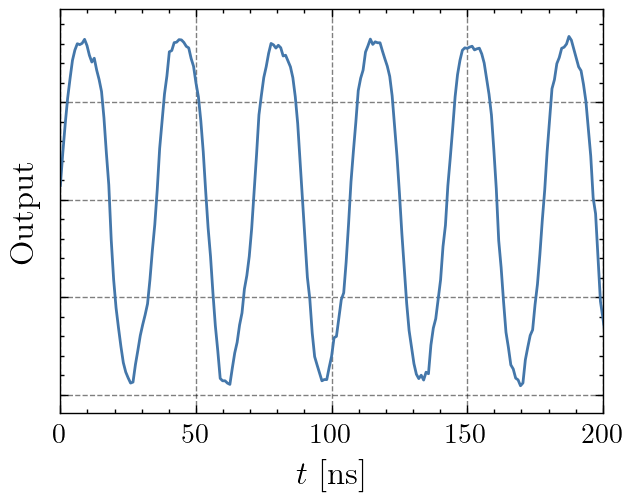

In [304]:
fig, ax = plt.subplots(dpi=200)
ax.plot(t, aligned_cosine_signal)
ax.set_ylabel("Output", fontsize='large')
ax.set_xlabel("$t$ [ns]", fontsize='large')
_ = ax.set_yticklabels("")
ax.set_xlim(0,200)
fig.savefig("plots/freq_manipulation/output_signal_cosine.svg", transparent=True)

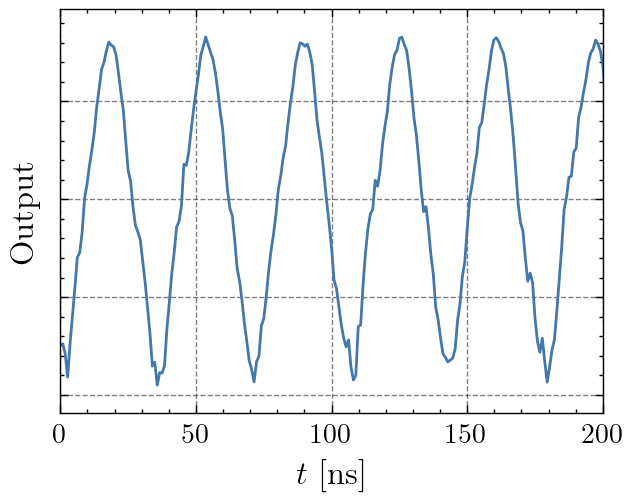

In [305]:
fig, ax = plt.subplots(dpi=200)
ax.plot(t, aligned_triangle_signal)
ax.set_ylabel("Output", fontsize='large')
ax.set_xlabel("$t$ [ns]", fontsize='large')
_ = ax.set_yticklabels("")
ax.set_xlim(0,200)
fig.savefig("plots/freq_manipulation/output_signal_triangle.svg", transparent=True)